This notebook uses cifar dataset to analyse best practices when training CNNs including using techniques like transfer learning and learning rate scheduling. 

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pdb
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os 
from tqdm import tqdm_notebook
import random

import torch
import torchvision
from torchvision import datasets, models, transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from clr import CyclicLR

In [3]:
path = "data/cifar10/"
use_gpu = torch.cuda.is_available()
batch_size=64

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        #transforms.Scale(224),
        #transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        #transforms.Scale(224),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ]),
}

In [5]:
image_datasets = {x: datasets.ImageFolder(os.path.join(path, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

In [6]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [262]:
sampler = torch.utils.data.sampler.SubsetRandomSampler(
    random.sample(range(len(image_datasets['val'])), batch_size*10))

dataloaders['finder'] = torch.utils.data.DataLoader(image_datasets['val'], batch_size,
                                             shuffle=False, sampler= sampler, num_workers=4)

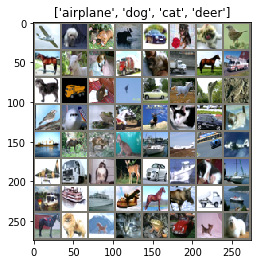

In [264]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.4914 ,  0.48216,  0.44653])
    std = np.array([0.24703,  0.24349,  0.26159])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['finder']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs.narrow(0,0,64))

imshow(out, title=[class_names[x] for x in classes[0:4]])

In [265]:
inputs.size()

torch.Size([64, 3, 32, 32])

## Models

### Simple CNN

In [266]:
class simpleCnn(nn.Module):
    def __init__(self):
        super(simpleCnn, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [267]:
class SimpleNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
        return F.log_softmax(l_x)

In [577]:
class ConvNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(layers[i], layers[i + 1], kernel_size=3, stride=2)
            for i in range(len(layers) - 1)])
        self.pool = nn.AdaptiveMaxPool2d(1)
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = F.relu(l(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x))

### img size 224 CNN

In [269]:
class simpleCnnL(nn.Module):
    def __init__(self):
        super(simpleCnnL, self).__init__()
        #Stride 1 and padding 0 (defaults)
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(4, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(4, 2)
        self.conv3 = nn.Conv2d(16, 32, 5)
        self.pool3 = nn.MaxPool2d(4, 2)
        self.conv4 = nn.Conv2d(32, 64, 5)
        self.pool4 = nn.MaxPool2d(4, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [270]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds  = x_chan.std (1)[:,None,None]
        return (x-self.means) / self.stds *self.m + self.a

In [271]:
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)

class Resnet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x))

In [272]:
#Plotting loss decrease over iterations
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # this locator puts ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [568]:
def find(model, criterion, optimizer, data, scheduler, max_step=50):
    acc = []
    lrs = []
    iters = 1
    corrects = 0
    for iters in tqdm_notebook(range(max_step)):  # loop over the dataset multiple times
        # get the inputs
        inputs, labels = next(iter(dataloaders['train']))

        if use_gpu:
            inputs = Variable(inputs.cuda())
            labels = Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)
        
        corrects = torch.sum(preds == labels.data)/64

        #scheduler.step()
        scheduler.batch_step()
        loss.backward()
        optimizer.step()
        iters += 1
        acc.append(corrects)
        lrs.append(scheduler.get_lr())

    return acc, lrs

In [474]:
def train(epochs, model, criterion, optimizer, dataloaders, scheduler, plot_every=100):
    plot_losses = []
    losses = []
    lrs = []
    plot_loss_total = 0 # Reset every plot_every
    iters = 0
    for epoch in tqdm_notebook(range(epochs)):  # loop over the dataset multiple times
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
                    
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                print (phase)
                if phase == 'train':
                    #scheduler.step()
                    scheduler.batch_step()
                    plot_loss_total += loss.data[0]
                    loss.backward()
                    optimizer.step()
                    iters += 1
                    if iters % plot_every == 0:
                        lrs.append(scheduler.get_lr())
                        losses.append(loss.data[0])
                        plot_loss_avg = plot_loss_total / plot_every
                        plot_losses.append(plot_loss_avg)
                        plot_loss_total = 0
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            if phase=='train':
                train_loss = epoch_loss; train_acc = epoch_acc
                continue
            print('Train Loss: {:.4f} Train Acc: {:.4f} Val Loss: {:.4f} Val Acc: {:.4f}'.format(
                train_loss, train_acc, epoch_loss, epoch_acc), end='\r', flush=True)
    return losses, lrs, plot_losses

Preferred Optimization technique is SGD with momentum, cyclic learning rates and cosine annealing. [This](https://arxiv.org/abs/1705.08292) paper puts a strong case for moving away from adaptive optimization methods like Adam. Validating results were also found in practice with the above model. Below is a description of the most effective method. <br>
<b>Stochastic Gradient Descent</b> optimizer with [momentum](https://distill.pub/2017/momentum/) is used. Now, a natural difficulty is finding the most appropriate learning rate. <br>
An interesting solution to this is <b>[Cyclical Learning Rates](https://arxiv.org/abs/1506.01186)</b>. In simple words, it is about increasing the learning rate from an estimate of a minimum to an estimate of a maximum in a specified amount of iterations. The hope is that by recording the loss and the learning rate, the range of valid learning rates can be narrowed down. Furthermore, this narrowed down range of learning rates can be used in multiple cycles where the learning rate rise and falls. This is a great way to get out of local minimas. <br>
Another addition is <b>[cosine annealing](https://arxiv.org/pdf/1608.03983.pdf)</b> and warm restarts to squeeze a bit more out of the narrowed down learning rates. Cosine annealing will be reintroduced in a clever trick later. 

### Finding optimal learning rates
This can be acheived by training for a step size which is equavalent to a incremental linear rise from base_lr to max_lr. Losses and learning rates can be plotted to identify which learning rates give optimal results.

In [569]:
net=SimpleNet([32*32*3, 40,10]).cuda()

In [578]:
net = ConvNet([3, 20, 40, 80], 10)
if use_gpu: net.cuda()

In [579]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [580]:
def plot_lr_loss(acc, lrs):
    plt.ylabel("Accuracy")
    plt.xlabel("learning rate (log scale)")
    plt.plot(lrs, acc)
    plt.xscale('log')

HBox(children=(IntProgress(value=0, max=120), HTML(value='')))

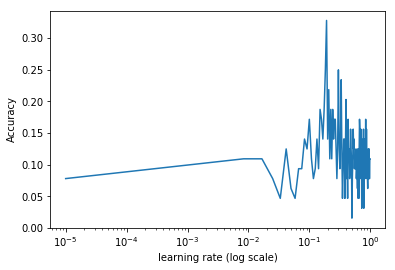

In [581]:
lrscheduler = CyclicLR(optimizer, base_lr=1e-5, max_lr=1, step_size=120, mode='triangular2', scale_mode='iterations')
#Comment scheduler.step() to disable cosine annealing
acc, lrs = find(net, criterion, optimizer, dataloaders,
                       lrscheduler, 120)
plot_lr_loss(acc, lrs)

In [583]:
acc

[0.078125,
 0.109375,
 0.109375,
 0.078125,
 0.046875,
 0.125,
 0.0625,
 0.046875,
 0.09375,
 0.09375,
 0.140625,
 0.125,
 0.171875,
 0.109375,
 0.078125,
 0.09375,
 0.140625,
 0.09375,
 0.1875,
 0.171875,
 0.140625,
 0.1875,
 0.25,
 0.328125,
 0.140625,
 0.21875,
 0.109375,
 0.1875,
 0.109375,
 0.1875,
 0.140625,
 0.171875,
 0.171875,
 0.125,
 0.078125,
 0.125,
 0.25,
 0.140625,
 0.09375,
 0.140625,
 0.234375,
 0.125,
 0.046875,
 0.09375,
 0.140625,
 0.140625,
 0.046875,
 0.125,
 0.203125,
 0.078125,
 0.109375,
 0.046875,
 0.171875,
 0.109375,
 0.125,
 0.078125,
 0.09375,
 0.15625,
 0.125,
 0.109375,
 0.015625,
 0.078125,
 0.109375,
 0.15625,
 0.125,
 0.140625,
 0.09375,
 0.109375,
 0.09375,
 0.09375,
 0.125,
 0.078125,
 0.09375,
 0.09375,
 0.0625,
 0.125,
 0.046875,
 0.125,
 0.046875,
 0.125,
 0.171875,
 0.15625,
 0.078125,
 0.125,
 0.15625,
 0.09375,
 0.125,
 0.03125,
 0.109375,
 0.109375,
 0.046875,
 0.140625,
 0.109375,
 0.15625,
 0.03125,
 0.140625,
 0.109375,
 0.109375,
 0.10937

In [514]:
acc

[0.03125,
 0.046875,
 0.15625,
 0.140625,
 0.1875,
 0.15625,
 0.234375,
 0.25,
 0.21875,
 0.203125,
 0.296875,
 0.1875,
 0.21875,
 0.265625,
 0.171875,
 0.15625,
 0.125,
 0.0625,
 0.09375,
 0.171875,
 0.171875,
 0.203125,
 0.125,
 0.0625,
 0.078125,
 0.140625,
 0.125,
 0.0625,
 0.15625,
 0.078125,
 0.140625,
 0.0625,
 0.171875,
 0.109375,
 0.140625,
 0.0625,
 0.078125,
 0.140625,
 0.15625,
 0.15625,
 0.109375,
 0.03125,
 0.171875,
 0.078125,
 0.09375,
 0.109375,
 0.125,
 0.125,
 0.203125,
 0.09375,
 0.1875,
 0.0625,
 0.1875,
 0.09375,
 0.109375,
 0.09375,
 0.125,
 0.078125,
 0.078125,
 0.125,
 0.078125,
 0.140625,
 0.125,
 0.140625,
 0.0625,
 0.140625,
 0.109375,
 0.140625,
 0.078125,
 0.09375,
 0.09375,
 0.21875,
 0.140625,
 0.125,
 0.0625,
 0.140625,
 0.171875,
 0.109375,
 0.078125,
 0.140625,
 0.078125,
 0.0625,
 0.140625,
 0.0625,
 0.09375,
 0.0625,
 0.15625,
 0.125,
 0.15625,
 0.09375,
 0.09375,
 0.0625,
 0.171875,
 0.109375,
 0.09375,
 0.09375,
 0.078125,
 0.125,
 0.109375,
 0.10

Best accuracy was observed with 8 epochs of cyclical learning rate and last 2 with cosine annealing. Uncomment the needed scheduler and comment out the other below and in training loop

In [ ]:
epochs = 8
lrscheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(dataloaders['train']), eta_min=0.0005)
#lrscheduler = CyclicLR(optimizer, base_lr=0.001, max_lr=0.008, step_size=5*len(dataloaders['train']))
#782 iterations in 1 epoch
losses, lrs, plot_losses = train(epochs, net, criterion, optimizer, dataloaders, lrscheduler)

In [ ]:
showPlot(plot_losses)

## Transfer learning

In [ ]:
resnet = models.resnet18(pretrained=True)
if use_gpu: resnet.cuda()
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 10).cuda()
if use_gpu:resnet.fc.cuda()

In [ ]:
epochs = 4
#lrscheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(dataloaders['train']), eta_min=0.0005)
lrscheduler = CyclicLR(optimizer, base_lr=0.002, max_lr=0.006, step_size=3*len(dataloaders['train']))
#782 iterations in 1 epoch
losses, lrs, plot_losses = train(epochs, resnet, criterion, optimizer, dataloaders, lrscheduler)
plot_lr_loss(losses, lrs)

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 10)

if use_gpu:
    model_conv.cuda()

In [ ]:
epochs = 24
#lrscheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(dataloaders['train']), eta_min=0.0005)
lrscheduler = CyclicLR(optimizer, base_lr=0.001, max_lr=0.006, step_size=4*len(dataloaders['train']))
losses, lrs, plot_losses = train(epochs, resnet, criterion, optimizer, dataloaders, lrscheduler)
plot_lr_loss(losses, lrs)

## Evaluation

In [ ]:
def evaluate_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()
    correct = 0
    total = 0
    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (preds.cpu().numpy() == labels.cpu().data.numpy()).sum()
        if i == len(dataloaders['val'])-1:
            print('Accuracy of the network on test images: %d %%' % (
                100 * correct / total))
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    return


In [ ]:
evaluate_model(resnet)